In [115]:
# To import functions from Phase_1.py and Phase_2.py
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

from Phase_1 import Phase1Pipeline, load_model_from_path
from Phase_2 import Phase2Pipeline


Problem structure (as given in the email)

**Regression model (time to next failure prediction)**
- Predict the time in cycles remaining until the next degradation stage (eg: from s1 to s2)
- models to use: **Random forest regressor**, **Ridge regression**, **SVR**, etc

Tips:
- Add an extra column that contains the number of cycles to the next phase
    - NOTE to self: the stage labels are noisy, so find a way to somehow reduce that noise
    - This noise occurs when the engine is changing stage(s) only.
- Evaluate using standard regession metrics like: **RMSE**, **MAE**, **R^2**

**My approach**
1. Load and preprocess data
    - [ ] Load into a master df
    - [ ] Create train-test splits (shuffle = False | the problem's temporal)
    - [ ] Filter training data, reduce the noise during stage-shift
    - [ ] Create new column in training data with the time (cycles) to next stage
        - [ ] This new column is the `y` data for training (this is what we want the model to pred)
2. EDA
    - [ ] Check which featuers are important
    - [ ] Feature scaling issues and allat
    - [ ] Drop features with near to no change in values
    - [ ] Compare time to next stage vs sensor measurement
        - Is there a sudden change in sensor measurement or is it gradual
        - If there is a change, then how can you model that
3. Start modeling ig
    - [ ] Random-forest regressor
    - [ ] Ridge regression (l1/l2 try em all)
    - [ ] SVR
    - [ ] Locally weighted linear regression (normal lin-reg wont work)
    - [ ] See what works best and try to move on from that


**ChatGPT helped me improve my apprach and POA, so here it is:**
1. Load and preprocess data
    - [ ] Load master dataframe from Phase-1
    - [ ] Select engines for train/test (ensure no leakage)
        - Use temporal split, i.e. engines 1-80 in train and 81-100 in test
    - [ ] Retain the useful columns from Phase-2
    - [ ] Add flag for stage change cycle per engine. Binary column: `is_transition = True`
    - [ ] Add a new target: `cycles_to_next_stage`
    - [ ] If no stage change exists (i.e. in last stage-4), then `-1`
    - [ ] Filter out samples that are too close to a transition, where label noise is high
    - [ ] Decide whether to train only within stages 0-3 (since 4 has no 'next')
2. Feature engineering
    - [ ] Drop flat/noisy sensors (based on Phase-2)
    - [ ] Normalize (or) Standardize sensor values
    - [ ] Add rolling stats (mean, std, min, max, slope) for each sensor over last N cycles.
        - Trying to capture as many of the temporal trends as possible
3. EDA
    - [ ] Viz the distribution of `cycles_to_next_stage`
    - [ ] Correlate sensor values vs `cycles_to_next_stage`
    - [ ] Plot moving averages of sensors neat transitions (do values shift before stage-change)
4. Modeling
    - [ ] Random forest regressor
    - [ ] Ridge regression
    - [ ] Lasso regression
    - [ ] SVR
    - [ ] Try gradient boosting regressor
    - [ ] Locally weighted regression
5. Evaluate
    - [ ] RMSE
    - [ ] MAE
    - [ ] $R^2$
    - [ ] Use cross validation for the same metrics
6. Post analysis
    - [ ] Viz actual vs predicted plots
    - [ ] Analyse worst predictions (large errors)
    - [ ] [EXTRA] Fearture importance per model
    - [ ] [EXTRA] Retain top-k features

**Approach refined**
1. Load and preprocess data
    - [ ] Load into a master df
    - [ ] Add `time_to_next_stage` label
    - [ ] Mask samples around stage transitions ($\pm3$ cycles)
    - [ ] Add lag features (trend info)
2. EDA
    - [ ] Sensor vs `time_to_next_stage` plots
    - [ ] Drop near constant features
    - [ ] Compare time to next stage vs sensor measurement
        - Is there a sudden change in sensor measurement or is it gradual
        - If there is a change, then how can you model that
3. Start modeling ig
    - [ ] Random-forest regressor
    - [ ] Ridge regression (l1/l2 try em all)
    - [ ] SVR
    - [ ] Locally weighted linear regression (normal lin-reg wont work)
    - [ ] Train seperate regressors
        - One for predicting time from Stage 0 to 1
        - One for predicting time from Stage 1 to 2
        - So on
4. Visualization
    - [ ] Pred vs actual curves
    - [ ] Error distribution per transition

# Load and preprocess data
- Load into a master df
- Add `time_to_next_stage` label
- Mask samples around stage transitions ($\pm3$ cycles)
- Add lag features (trend info)

In [116]:
# Load data
import os
import pandas as pd
curr_dir = Path(os.getcwd())
data_dir = curr_dir.parent / "Phase_1" / "train_FD001_phase_1.csv"
df = pd.read_csv(data_dir)
df.head()

Engine no  Num cycles  Operating 1  Operating 2  Operating 3  Sensor 1  \
0          1           2       0.0019      -0.0003        100.0    518.67   
1          1           3      -0.0043       0.0003        100.0    518.67   
2          1           4       0.0007       0.0000        100.0    518.67   
3          1           5      -0.0019      -0.0002        100.0    518.67   
4          1           6      -0.0043      -0.0001        100.0    518.67   

   Sensor 2  Sensor 3  Sensor 4  Sensor 5  ...  Sensor 13  Sensor 14  \
0    642.15   1591.82   1403.14     14.62  ...    2388.07    8131.49   
1    642.35   1587.99   1404.20     14.62  ...    2388.03    8133.23   
2    642.35   1582.79   1401.87     14.62  ...    2388.08    8133.83   
3    642.37   1582.85   1406.22     14.62  ...    2388.04    8133.80   
4    642.10   1584.47   1398.37     14.62  ...    2388.03    8132.85   

   Sensor 15  Sensor 16  Sensor 17  Sensor 18  Sensor 19  Sensor 20  \
0     8.4318       0.03        392       2388      100.0      39.00   
1     8.4178       0.03        390       2388      100.0      38.95   
2     8.3682       0.03        392       2388      100.0      38.88   
3     8.4294       0.03        393       2388      100.0      38.90   
4     8.4108       0.03        391       2388      100.0      38.98   

   Sensor 21  Stage  
0    23.4236      0  
1    23.3442      0  
2    23.3739      0  
3    23.4044      0  
4    23.3669      0  

[5 rows x 27 columns]

In [117]:
# Add the `time_to_next_stage` column
import numpy as np

def compute_time_to_next_stage(df, window=3):
    result = []
    engines = df["Engine no"].unique()
    
    for engine in engines:
        sub_df = df[df["Engine no"] == engine].copy()
        stages = sub_df["Stage"].to_numpy()
        cycles = sub_df["Num cycles"].to_numpy()
        n = len(stages)
        y = [-1] * n

        for i in reversed(range(n-1)):
            if stages[i] != stages[i+1]:
                y[i] = 1
            elif y[i+1] != -1:
                y[i] = y[i+1] + 1

        clean_mask = [True] * n
        for i in range(1, n):
            if stages[i] != stages[i-1]:
                for j in range(max(0, i - window), min(n, i + window + 1)):
                    clean_mask[j] = False
        
        for i in range(n):
            result.append(y[i] if clean_mask[i] else np.nan)
    return result

df_clean = df.copy()
df_clean["time_to_next_stage"] = compute_time_to_next_stage(df_clean, window=1)
df_clean.head()

Engine no  Num cycles  Operating 1  Operating 2  Operating 3  Sensor 1  \
0          1           2       0.0019      -0.0003        100.0    518.67   
1          1           3      -0.0043       0.0003        100.0    518.67   
2          1           4       0.0007       0.0000        100.0    518.67   
3          1           5      -0.0019      -0.0002        100.0    518.67   
4          1           6      -0.0043      -0.0001        100.0    518.67   

   Sensor 2  Sensor 3  Sensor 4  Sensor 5  ...  Sensor 14  Sensor 15  \
0    642.15   1591.82   1403.14     14.62  ...    8131.49     8.4318   
1    642.35   1587.99   1404.20     14.62  ...    8133.23     8.4178   
2    642.35   1582.79   1401.87     14.62  ...    8133.83     8.3682   
3    642.37   1582.85   1406.22     14.62  ...    8133.80     8.4294   
4    642.10   1584.47   1398.37     14.62  ...    8132.85     8.4108   

   Sensor 16  Sensor 17  Sensor 18  Sensor 19  Sensor 20  Sensor 21  Stage  \
0       0.03        392       2388      100.0      39.00    23.4236      0   
1       0.03        390       2388      100.0      38.95    23.3442      0   
2       0.03        392       2388      100.0      38.88    23.3739      0   
3       0.03        393       2388      100.0      38.90    23.4044      0   
4       0.03        391       2388      100.0      38.98    23.3669      0   

   time_to_next_stage  
0                13.0  
1                12.0  
2                11.0  
3                10.0  
4                 9.0  

[5 rows x 28 columns]

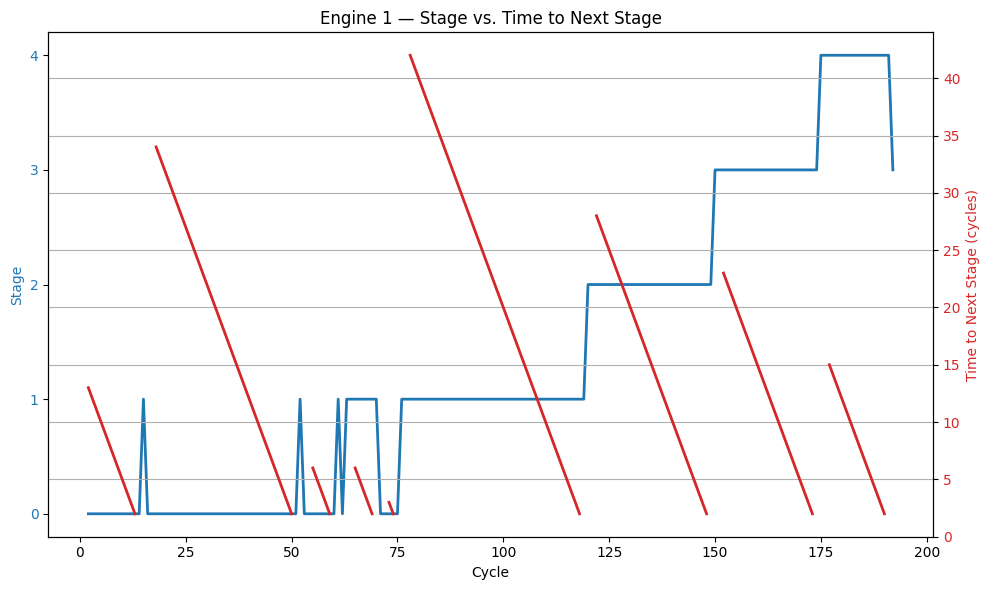

In [118]:
# Plot 'time_to_next_stage' for some of the engines
import matplotlib.pyplot as plt

def plot_time_to_next_stage(df, engine_no: int):
    engine_df = df[df["Engine no"] == engine_no]
    cycles = engine_df["Num cycles"]
    stages = engine_df["Stage"]
    times = engine_df["time_to_next_stage"]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Primary Y-axis for Stages
    ax1.plot(cycles, stages, color="tab:blue", label="Stage", linewidth=2)
    ax1.set_xlabel("Cycle")
    ax1.set_ylabel("Stage", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.set_yticks(sorted(df["Stage"].unique()))

    # Secondary Y-axis for time to next stage
    ax2 = ax1.twinx()
    ax2.plot(cycles, times, color="tab:red", label="Time to Next Stage", linewidth=2)
    ax2.set_ylabel("Time to Next Stage (cycles)", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # Title and grid
    plt.title(f"Engine {engine_no} — Stage vs. Time to Next Stage")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

plot_time_to_next_stage(df_clean, 1)

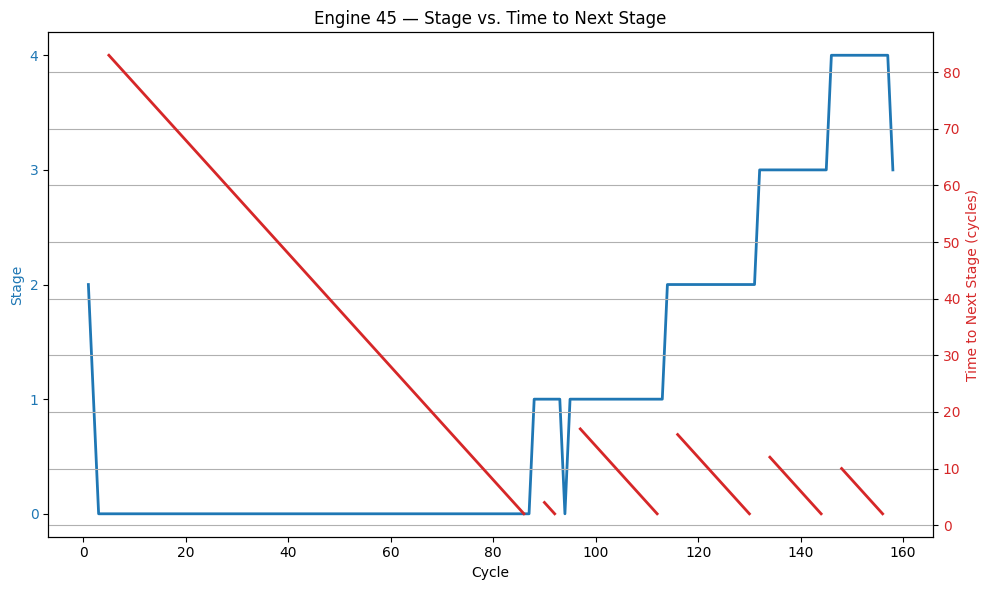

In [119]:
plot_time_to_next_stage(df_clean, 45)

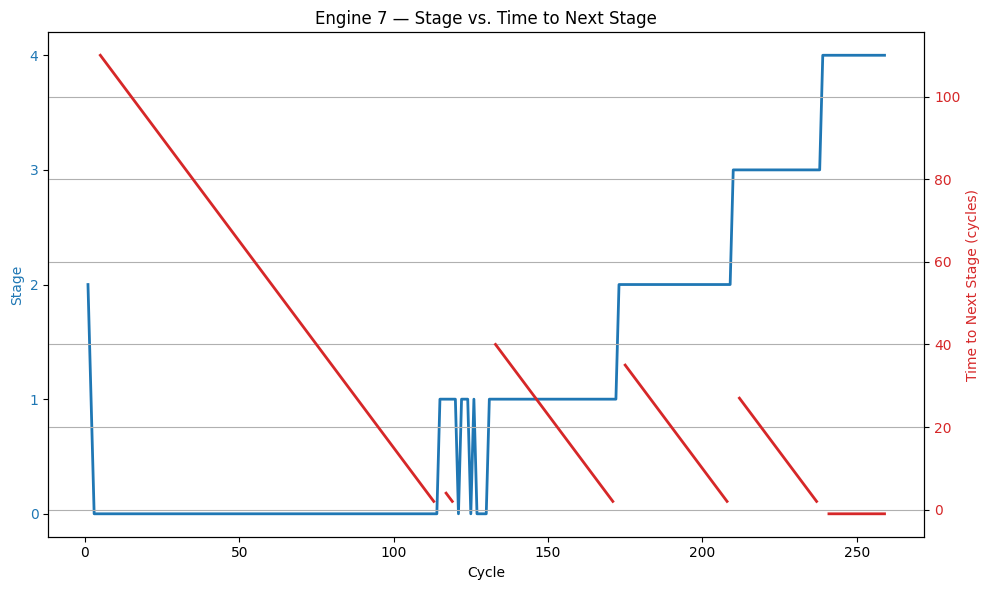

In [120]:
plot_time_to_next_stage(df_clean, 7)

There seem to be many outliers from the class labels, lets try to remove them.

In [121]:
# Clipping the start and end of a engine-stage
def trim_stage_outliers(df, trim_window=5):
    clean_indices = []
    for eng in df["Engine no"].unique():
        eng_df = df[df["Engine no"] == eng]
        stages = eng_df["Stage"].to_numpy()
        idxs = eng_df.index.to_numpy()

        # Check beginning
        head = stages[:trim_window]
        head_mode = np.bincount(head).argmax()
        for i in range(trim_window):
            if stages[i] == head_mode:
                clean_indices.append(idxs[i])

        # Middle part (trusted)
        clean_indices.extend(idxs[trim_window:-trim_window])

        # Check end
        tail = stages[-trim_window:]
        tail_mode = np.bincount(tail).argmax()
        for i in range(-trim_window, 0):
            if stages[i] == tail_mode:
                clean_indices.append(idxs[i])

    return df.loc[sorted(set(clean_indices))].reset_index(drop=True)

temp_df = trim_stage_outliers(df_clean, trim_window=5)

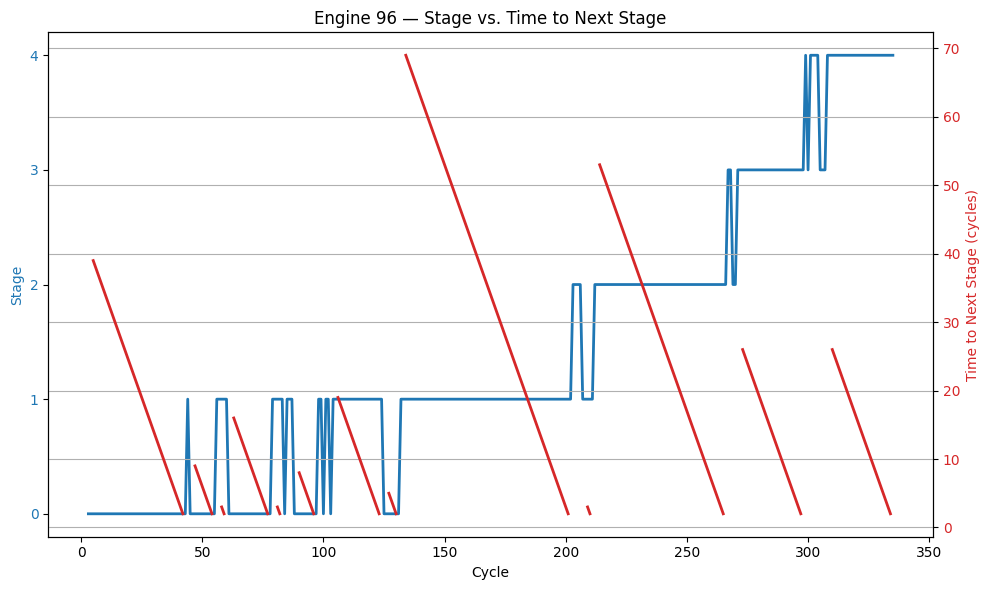

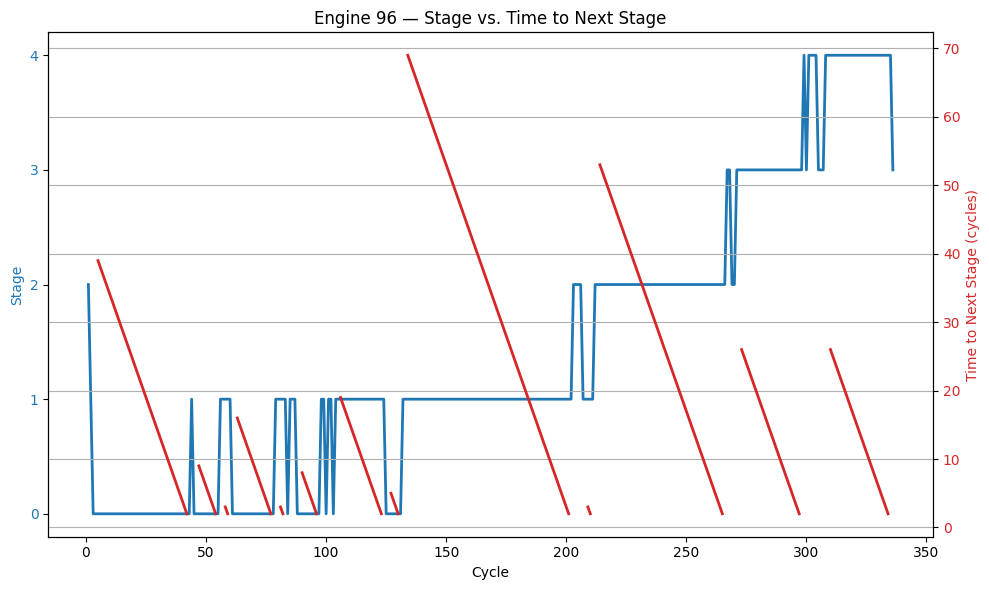

In [122]:
plot_time_to_next_stage(temp_df, 96)
plot_time_to_next_stage(df_clean, 96)

In [123]:
# Split into train-test
train_df = df[df["Engine no"] <= 80]
test_df = df[df["Engine no"] > 80]
train_df.shape, test_df.shape

((16137, 27), (4493, 27))

In [124]:
train_df.head()

Engine no  Num cycles  Operating 1  Operating 2  Operating 3  Sensor 1  \
0          1           2       0.0019      -0.0003        100.0    518.67   
1          1           3      -0.0043       0.0003        100.0    518.67   
2          1           4       0.0007       0.0000        100.0    518.67   
3          1           5      -0.0019      -0.0002        100.0    518.67   
4          1           6      -0.0043      -0.0001        100.0    518.67   

   Sensor 2  Sensor 3  Sensor 4  Sensor 5  ...  Sensor 13  Sensor 14  \
0    642.15   1591.82   1403.14     14.62  ...    2388.07    8131.49   
1    642.35   1587.99   1404.20     14.62  ...    2388.03    8133.23   
2    642.35   1582.79   1401.87     14.62  ...    2388.08    8133.83   
3    642.37   1582.85   1406.22     14.62  ...    2388.04    8133.80   
4    642.10   1584.47   1398.37     14.62  ...    2388.03    8132.85   

   Sensor 15  Sensor 16  Sensor 17  Sensor 18  Sensor 19  Sensor 20  \
0     8.4318       0.03        392       2388      100.0      39.00   
1     8.4178       0.03        390       2388      100.0      38.95   
2     8.3682       0.03        392       2388      100.0      38.88   
3     8.4294       0.03        393       2388      100.0      38.90   
4     8.4108       0.03        391       2388      100.0      38.98   

   Sensor 21  Stage  
0    23.4236      0  
1    23.3442      0  
2    23.3739      0  
3    23.4044      0  
4    23.3669      0  

[5 rows x 27 columns]

In [125]:
test_df.head()

Engine no  Num cycles  Operating 1  Operating 2  Operating 3  Sensor 1  \
16137         81           1      -0.0050       0.0003        100.0    518.67   
16138         81           2       0.0023       0.0002        100.0    518.67   
16139         81           3      -0.0005       0.0005        100.0    518.67   
16140         81           4      -0.0001      -0.0000        100.0    518.67   
16141         81           5       0.0024       0.0002        100.0    518.67   

       Sensor 2  Sensor 3  Sensor 4  Sensor 5  ...  Sensor 13  Sensor 14  \
16137    642.04   1589.91   1406.63     14.62  ...    2388.04    8134.78   
16138    642.65   1586.25   1407.88     14.62  ...    2388.07    8140.37   
16139    642.55   1586.42   1396.40     14.62  ...    2388.06    8139.75   
16140    642.41   1594.89   1404.86     14.62  ...    2388.04    8144.12   
16141    643.41   1590.49   1409.58     14.62  ...    2388.12    8139.21   

       Sensor 15  Sensor 16  Sensor 17  Sensor 18  Sensor 19  Sensor 20  \
16137     8.4455       0.03        391       2388      100.0      38.87   
16138     8.4573       0.03        392       2388      100.0      38.91   
16139     8.4522       0.03        394       2388      100.0      39.04   
16140     8.4403       0.03        392       2388      100.0      38.77   
16141     8.3971       0.03        392       2388      100.0      39.04   

       Sensor 21  Stage  
16137    23.3365      3  
16138    23.3452      2  
16139    23.3610      1  
16140    23.4206      1  
16141    23.3311      1  

[5 rows x 27 columns]

EDA

In [126]:
# Cell X: Mask ±3 cycles around each stage change, then add sensor deltas as lag features

import numpy as np

# 1) Mask ±3 cycles around transitions
mask_window = 3
df_model = df_clean.copy()

# create a boolean mask: True if within ±3 of any stage change
change_idx = df_model.index[df_model["Stage"].diff().abs() == 1]
mask = np.zeros(len(df_model), dtype=bool)
for idx in change_idx:
    start = max(0, idx - mask_window)
    end   = min(len(df_model) - 1, idx + mask_window)
    mask[start : end + 1] = True

# apply mask: set target to NaN where mask==True
df_model.loc[mask, "time_to_next_stage"] = np.nan

# 2) Add first‐difference (lag) features for each sensor
sensor_cols = [c for c in df_model.columns if c.startswith("Sensor ")]
for s in sensor_cols:
    df_model[f"{s}_delta1"] = df_model.groupby("Engine no")[s].diff().fillna(0)

# 3) Drop rows now missing the target
df_model = df_model.dropna(subset=["time_to_next_stage"]).reset_index(drop=True)

# Preview
df_model.head()



Engine no  Num cycles  Operating 1  Operating 2  Operating 3  Sensor 1  \
0          1           2       0.0019      -0.0003        100.0    518.67   
1          1           3      -0.0043       0.0003        100.0    518.67   
2          1           4       0.0007       0.0000        100.0    518.67   
3          1           5      -0.0019      -0.0002        100.0    518.67   
4          1           6      -0.0043      -0.0001        100.0    518.67   

   Sensor 2  Sensor 3  Sensor 4  Sensor 5  ...  Sensor 12_delta1  \
0    642.15   1591.82   1403.14     14.62  ...              0.00   
1    642.35   1587.99   1404.20     14.62  ...              0.14   
2    642.35   1582.79   1401.87     14.62  ...              0.44   
3    642.37   1582.85   1406.22     14.62  ...             -0.67   
4    642.10   1584.47   1398.37     14.62  ...             -0.51   

   Sensor 13_delta1  Sensor 14_delta1  Sensor 15_delta1  Sensor 16_delta1  \
0              0.00              0.00            0.0000               0.0   
1             -0.04              1.74           -0.0140               0.0   
2              0.05              0.60           -0.0496               0.0   
3             -0.04             -0.03            0.0612               0.0   
4             -0.01             -0.95           -0.0186               0.0   

   Sensor 17_delta1  Sensor 18_delta1  Sensor 19_delta1  Sensor 20_delta1  \
0               0.0               0.0               0.0              0.00   
1              -2.0               0.0               0.0             -0.05   
2               2.0               0.0               0.0             -0.07   
3               1.0               0.0               0.0              0.02   
4              -2.0               0.0               0.0              0.08   

   Sensor 21_delta1  
0            0.0000  
1           -0.0794  
2            0.0297  
3            0.0305  
4           -0.0375  

[5 rows x 49 columns]

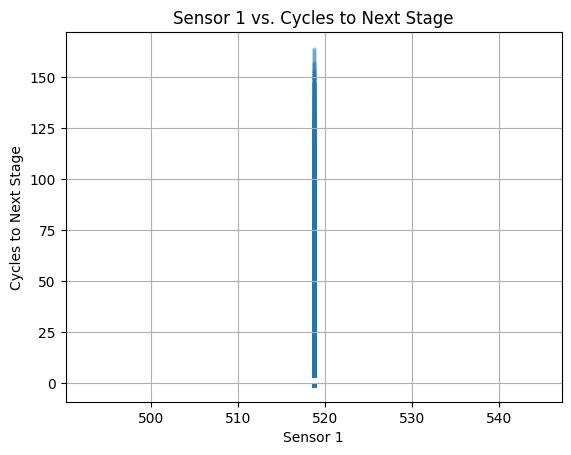

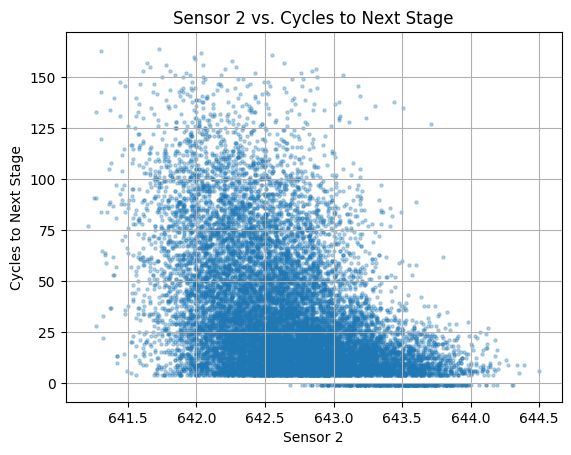

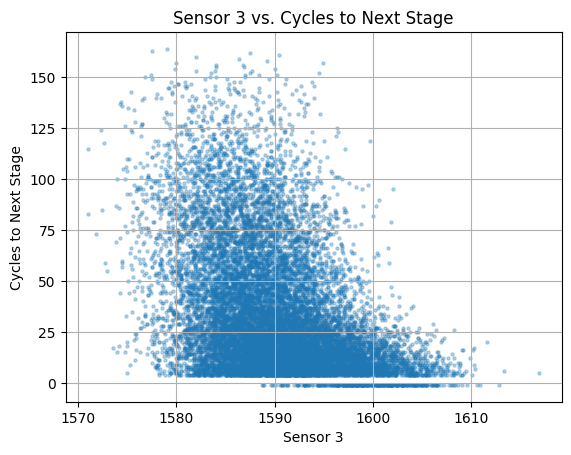

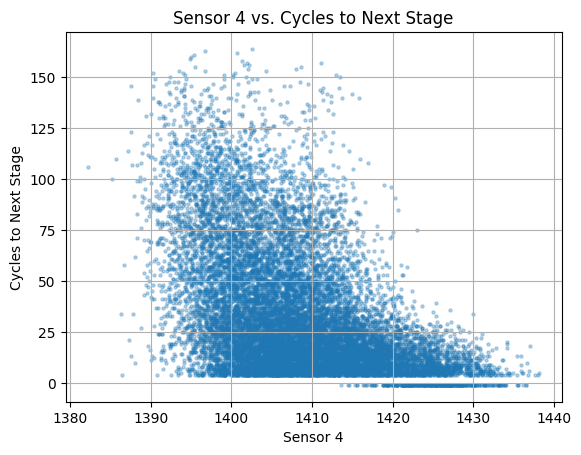

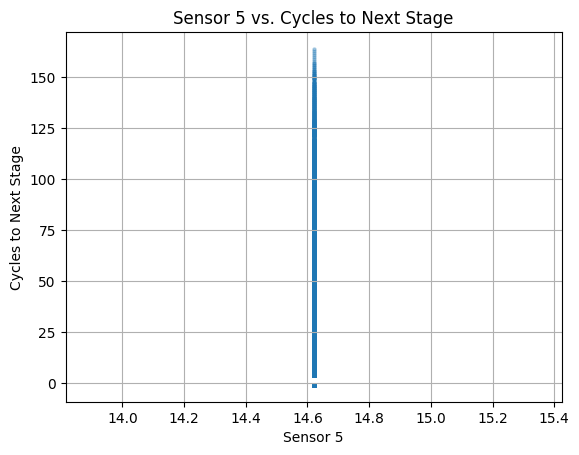

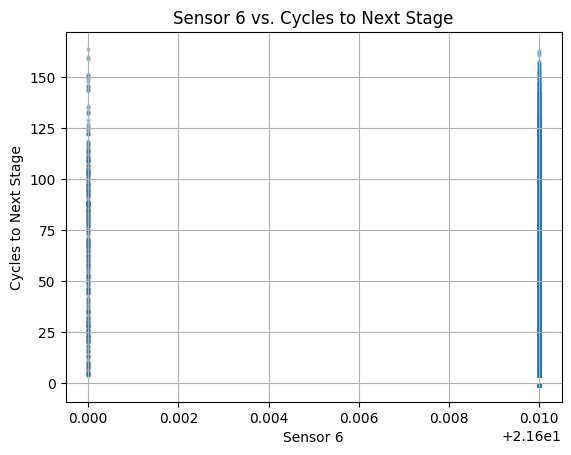

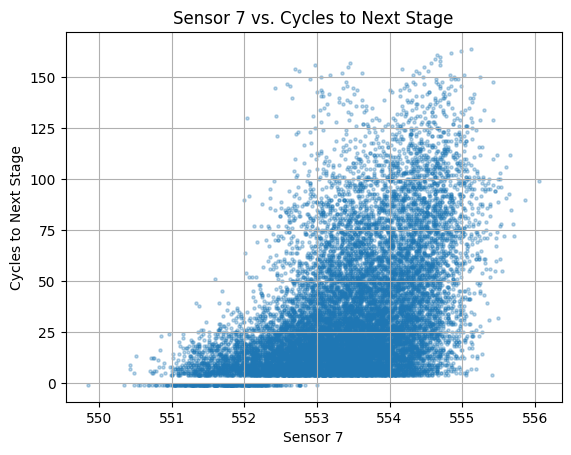

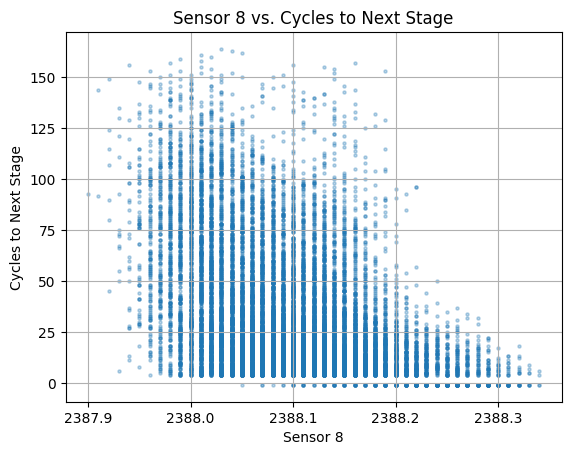

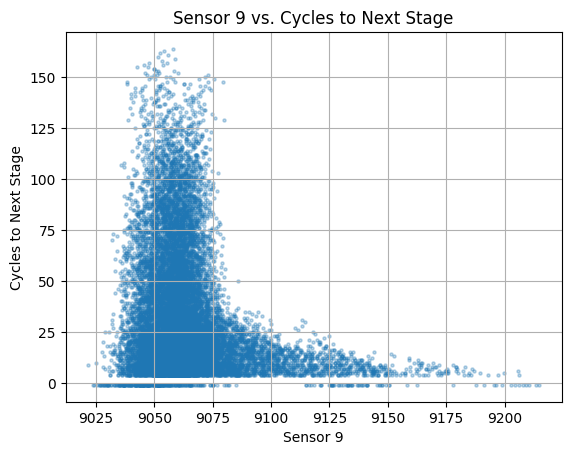

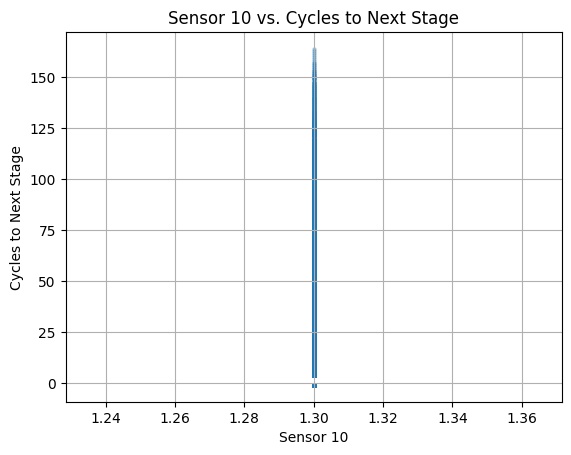

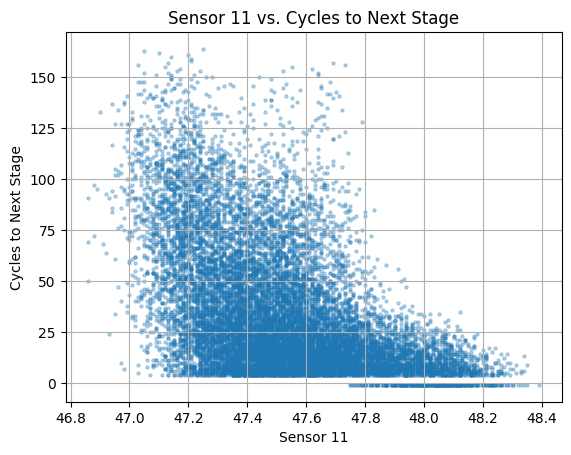

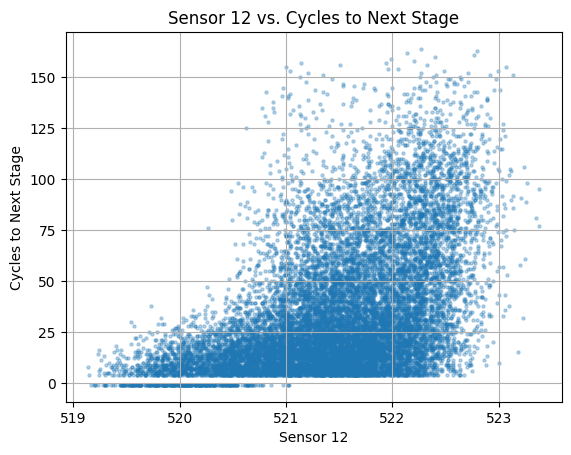

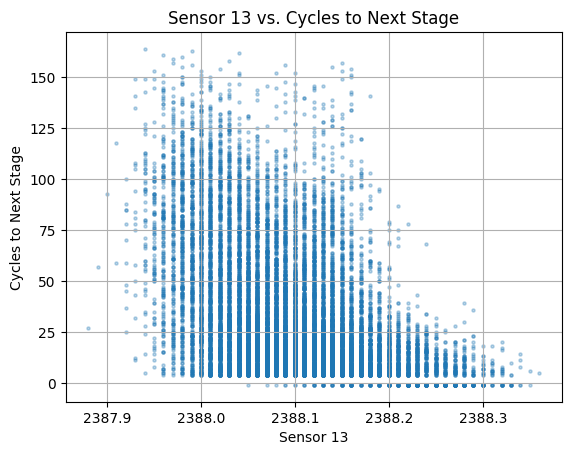

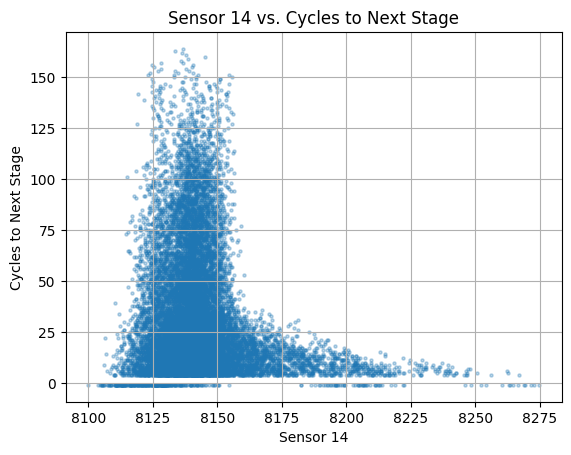

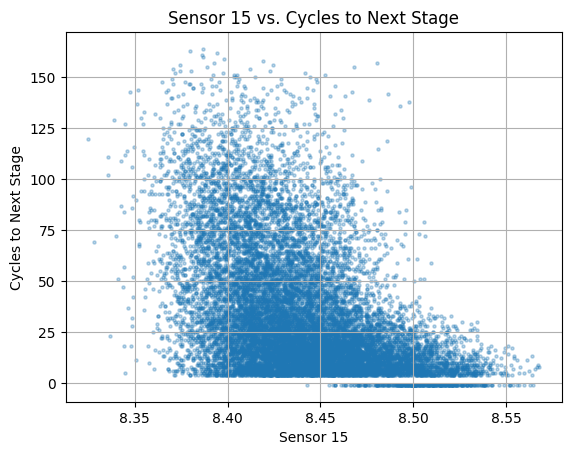

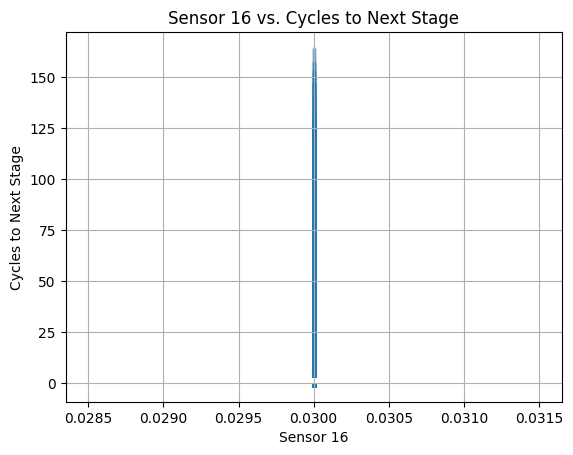

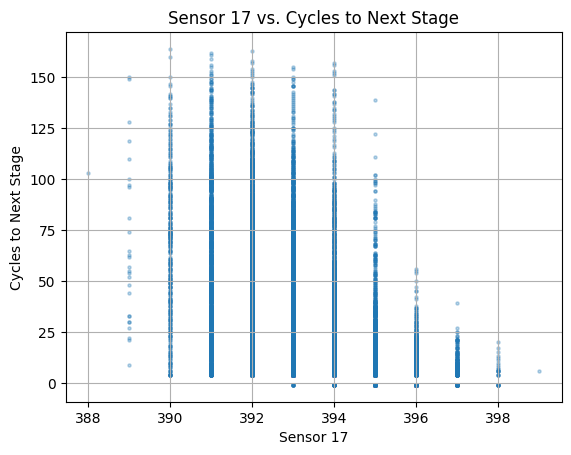

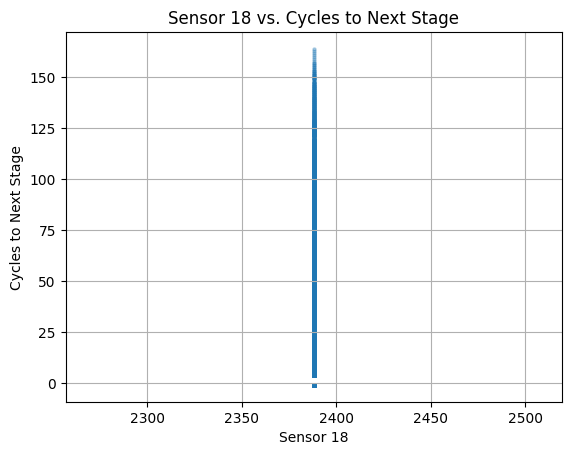

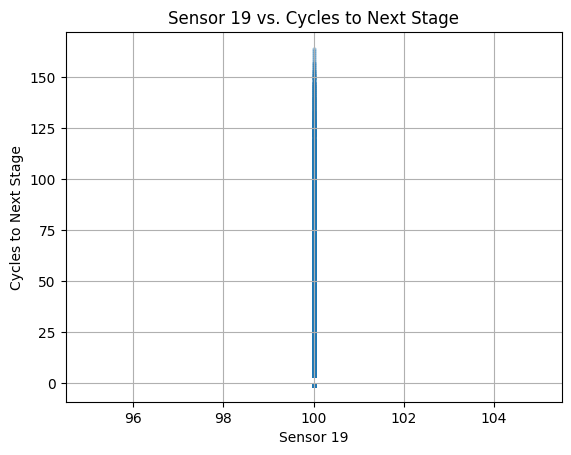

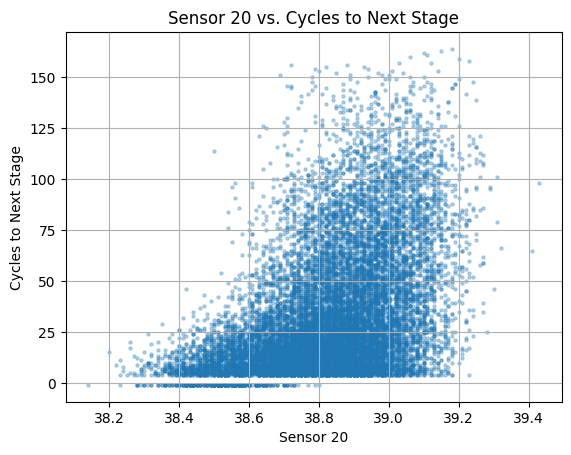

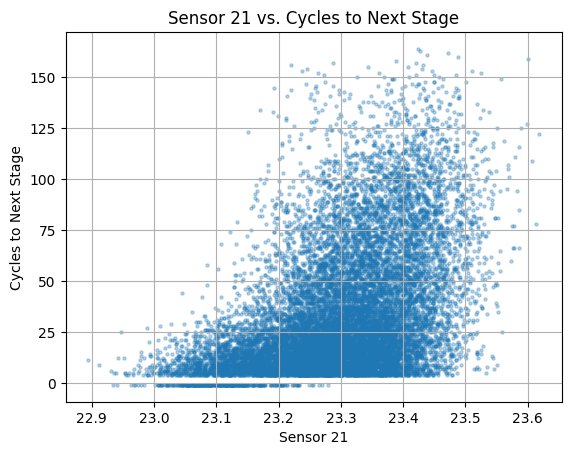

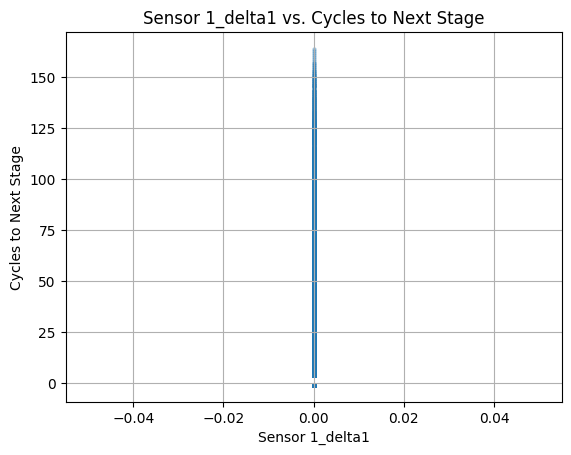

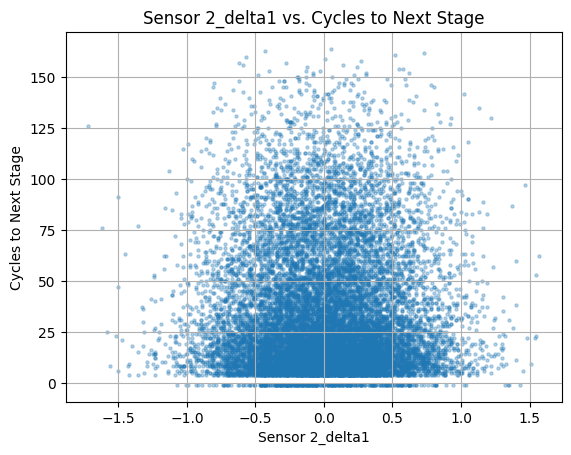

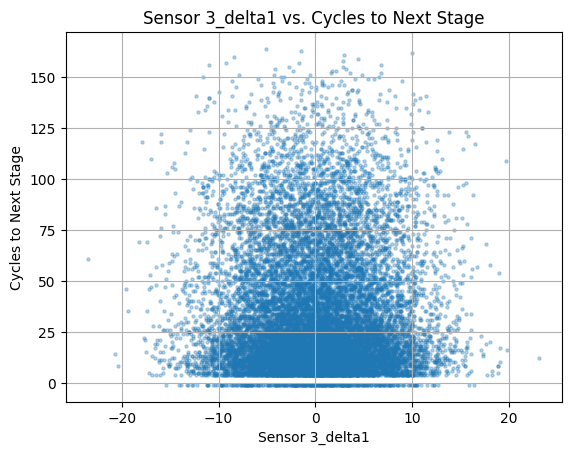

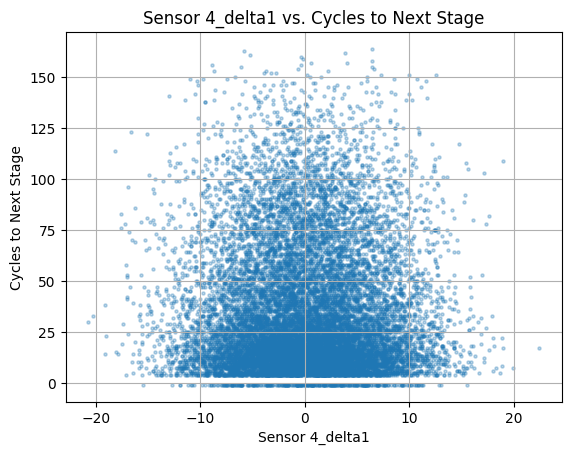

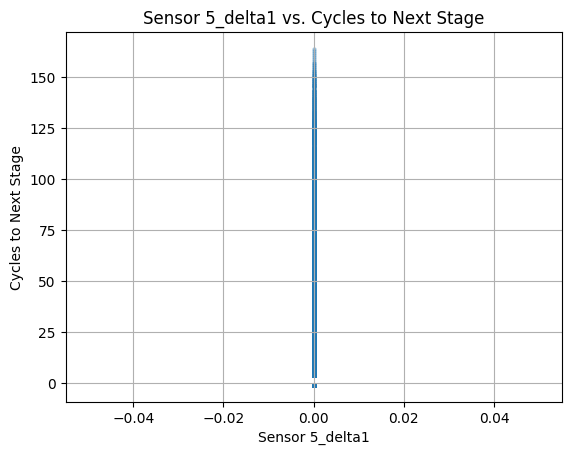

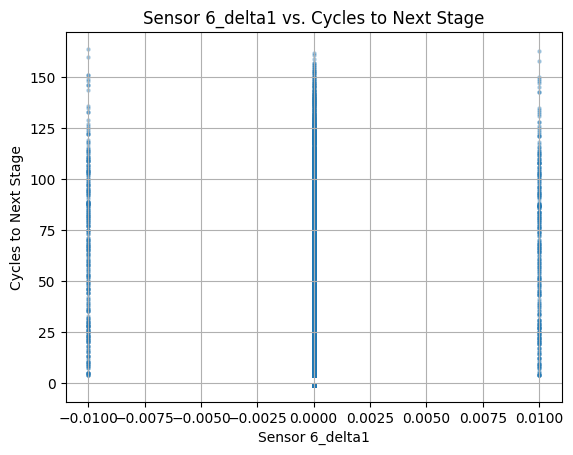

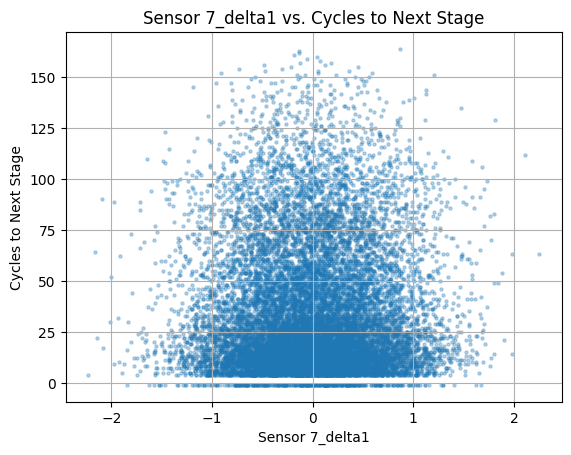

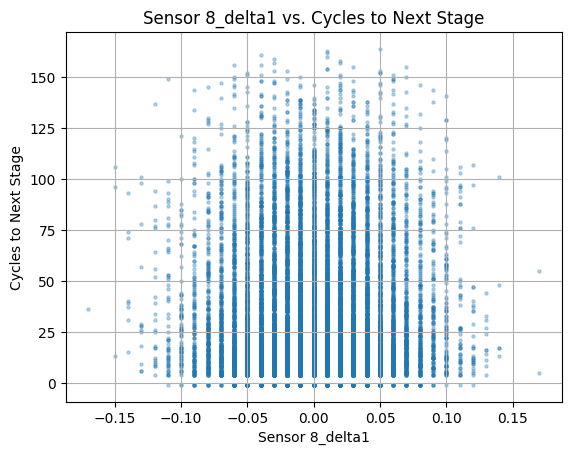

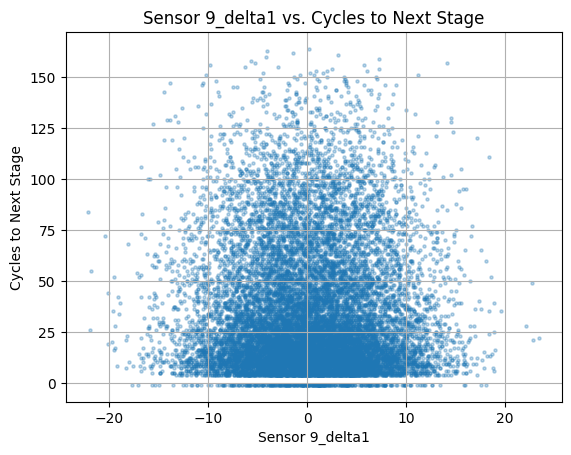

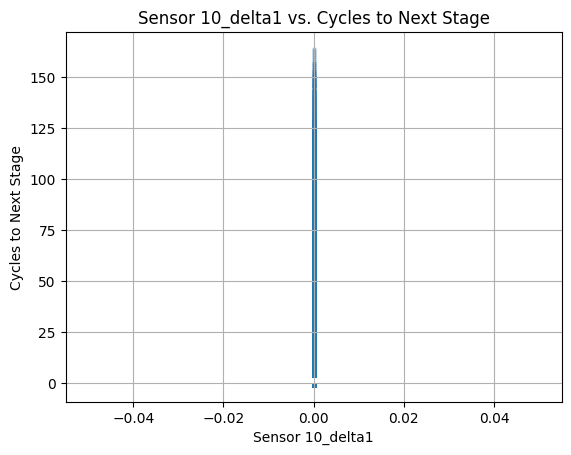

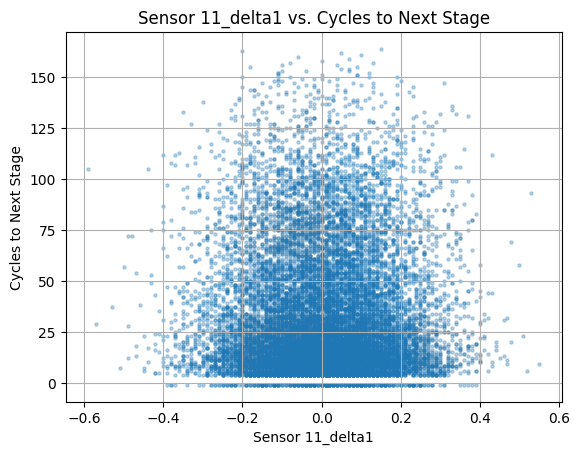

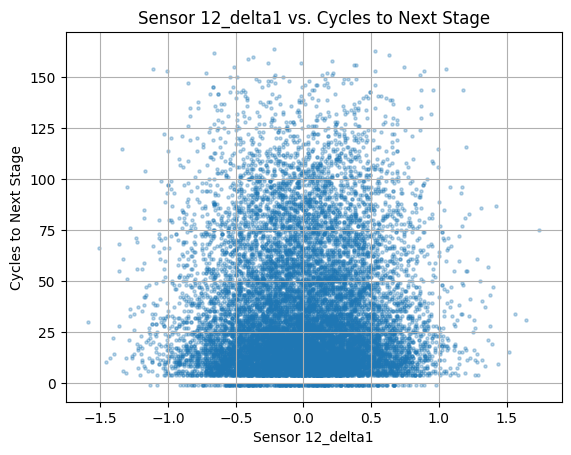

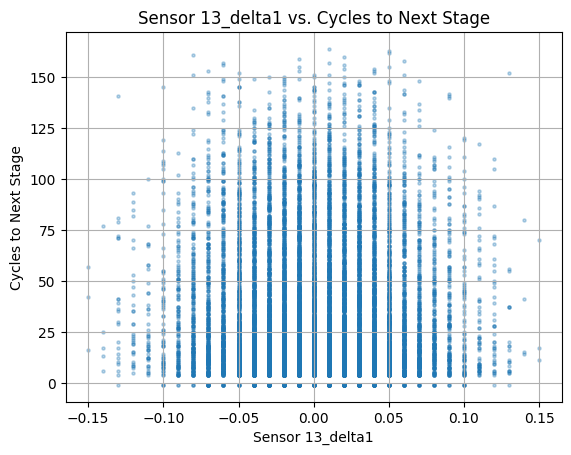

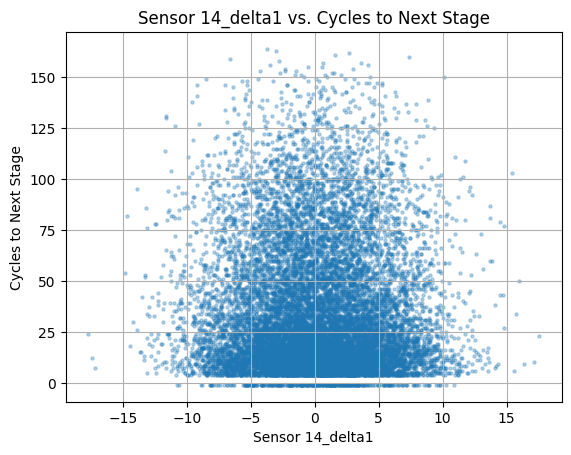

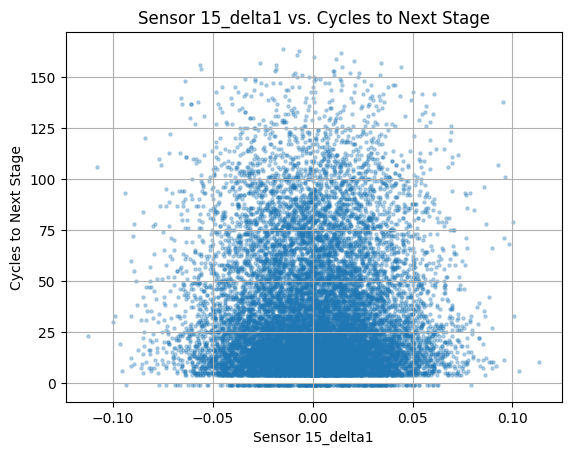

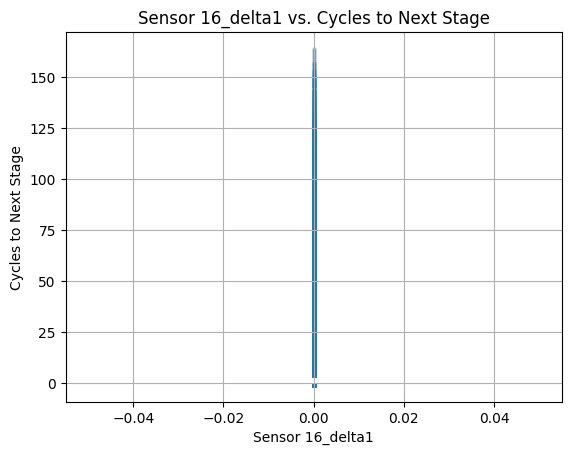

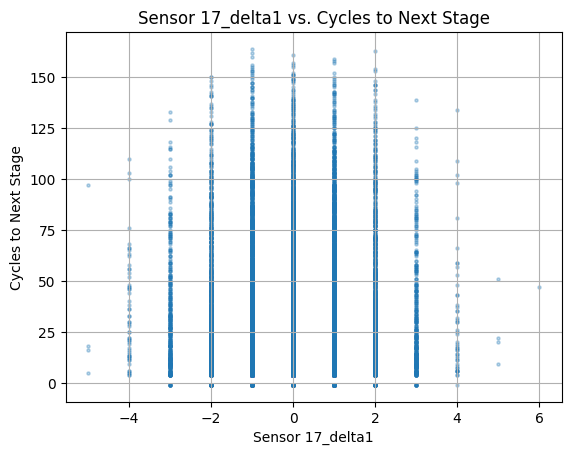

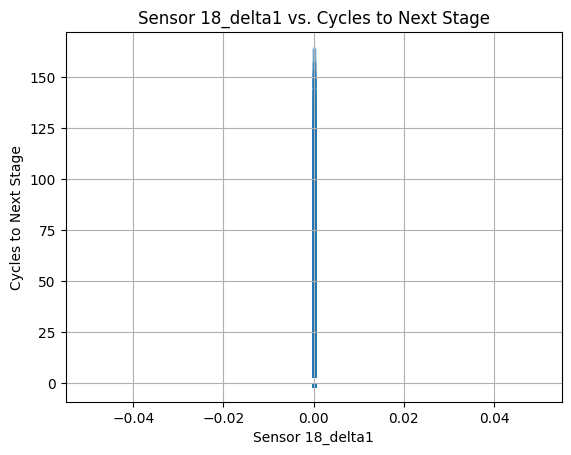

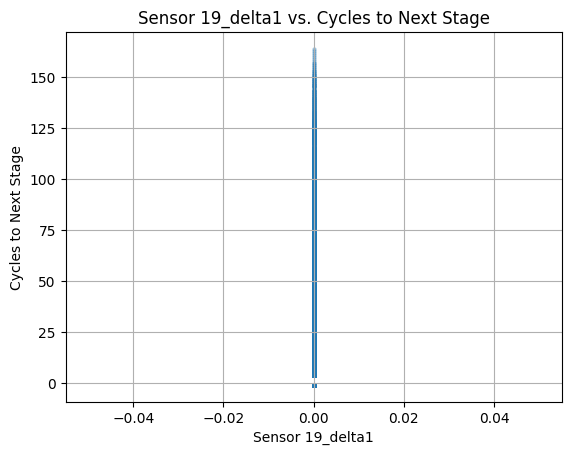

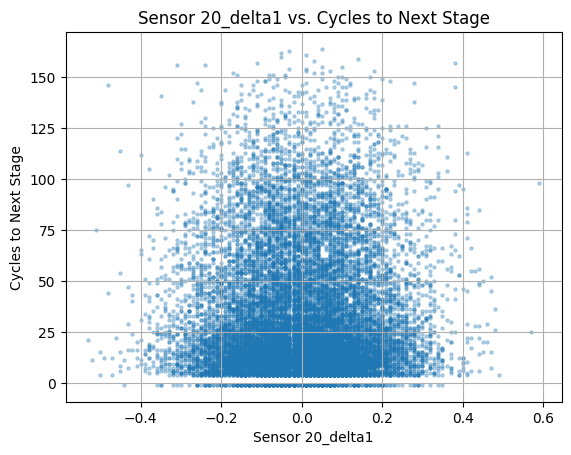

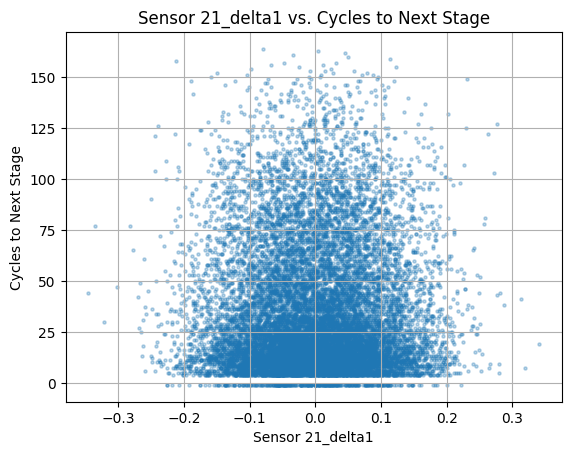

In [127]:
# Cell: Sensor vs. Target Scatterplots for All Sensors

import matplotlib.pyplot as plt

# Use only valid rows
plot_df = df_model.copy()

# Identify sensor columns
sensor_cols = [c for c in plot_df.columns if c.startswith("Sensor ")]

# Create one scatter per sensor
for s in sensor_cols:
    plt.figure()
    plt.scatter(plot_df[s], plot_df["time_to_next_stage"], alpha=0.3, s=5)
    plt.title(f"{s} vs. Cycles to Next Stage")
    plt.xlabel(s)
    plt.ylabel("Cycles to Next Stage")
    plt.grid(True)
    plt.show()


In [128]:
const_sensors = [f"Sensor {i}" for i in [1, 5, 10, 16, 18, 19]] + [f"Sensor {i}_delta1" for i in [1, 5, 10, 16, 18, 19]]

df_model.drop(columns=const_sensors, axis=1, inplace=True)
df_model.head()

print(f"Dropped the following sensors with very less variance : {const_sensors}")

Dropped the following sensors with very less variance : ['Sensor 1', 'Sensor 5', 'Sensor 10', 'Sensor 16', 'Sensor 18', 'Sensor 19', 'Sensor 1_delta1', 'Sensor 5_delta1', 'Sensor 10_delta1', 'Sensor 16_delta1', 'Sensor 18_delta1', 'Sensor 19_delta1']


# RandomForest

In [129]:

# Cell: Train/Test Split & RandomForest Baseline

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Split by engine ID
train_df = df_model[df_model["Engine no"] <= 80]
test_df  = df_model[df_model["Engine no"]  > 80]

# 2) Define feature columns (everything except Engine no, Num cycles, Stage, target)
exclude = {"Engine no", "Num cycles", "Stage", "time_to_next_stage"}
feature_cols = [c for c in df_model.columns if c not in exclude]

# 3) Build train/test matrices
X_train, y_train = train_df[feature_cols].values, train_df["time_to_next_stage"].values
X_test,  y_test  = test_df [feature_cols].values, test_df ["time_to_next_stage"].values

# 4) Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Compute MSE then take square root for RMSE
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("RMSE:", rmse)
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("R2:  ", r2_score(y_test, y_pred))

RMSE: 29.242952822087172
MAE:  20.783762405137185
R2:   0.2806671624799617


In [130]:
# Cell: GridSearchCV for XGBRegressor

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Define param grid (feel free to expand)
param_grid = {
    "n_estimators": [100, 200],
    "max_depth":    [3, 5, 7],
    "learning_rate":[0.05, 0.1]
}

# 2) Set up XGBRegressor
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    verbosity=0
)

# 3) Grid search with 3-fold CV (on training data only)
gs = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

# 4) Fit
gs.fit(X_train, y_train)

# 5) Best params and CV score
print("Best params:", gs.best_params_)
print("Best CV RMSE:", -gs.best_score_)

# 6) Evaluate on test set
best_xgb = gs.best_estimator_
y_pred_gs = best_xgb.predict(X_test)

rmse_gs = np.sqrt(mean_squared_error(y_test, y_pred_gs))
mae_gs  = mean_absolute_error(y_test, y_pred_gs)
r2_gs   = r2_score(y_test, y_pred_gs)

print(f"Test RMSE: {rmse_gs:.3f}")
print(f"Test MAE:  {mae_gs:.3f}")
print(f"Test R2:   {r2_gs:.3f}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best CV RMSE: 21.93324491711573
Test RMSE: 29.155
Test MAE:  20.567
Test R2:   0.285
